In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from tqdm import tqdm


In [2]:
transformations = transforms.Compose([transforms.ToTensor(), 
                        transforms.Lambda(lambda img: img.squeeze().reshape(784))])

trans_target = lambda label: F.one_hot(torch.tensor(label), num_classes=10)


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformations , target_transform=trans_target)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformations , target_transform=trans_target)
# fig, ax = plt.subplots(nrows=1, ncols=1)
# ax.imshow(img, cmap=plt.cm.gray)
%config Completer.use_jedi = False


The label for this image is: 5


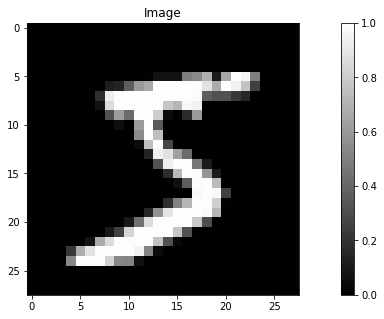

In [3]:
# Visualizing the images and lables
fig, ax = plt.subplots()
fig.set_size_inches(15,5)

img = train_dataset[0][0].numpy().reshape(28, 28)
im = ax.imshow(img, cmap=plt.cm.gray)
fig.colorbar(im)
ax.set_title("Image")
print(f"The label for this image is: {train_dataset[0][1].argmax()}")

In [4]:
#Dataloader 
batch_size = 20
train_loader = DataLoader(
                dataset= train_dataset,
                batch_size=batch_size,
                shuffle=False) 
test_loader = DataLoader(
                dataset = test_dataset,
                batch_size=batch_size,
                shuffle=True)


In [14]:
class NeuralNet():
    def __init__(self, LR, batch_size):
        np.random.seed(0)

        self.layer1 = np.random.uniform(-0.5, 0.5, (784, 64))
        self.layer2 = np.random.uniform(-0.5, 0.5, (64, 10))
        self.bias1 = np.zeros((1, 64))
        self.bias2 = np.zeros((1,10))
        self.batch_size = batch_size
        self.LR = LR
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def softmax(self, z):
        ez = np.exp(z/z.max())
        sum_ez = np.sum(ez, axis=0)
        return ez / (sum_ez)    
    
    def d_sigmoid(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def d_softmax(self, a, y):
        result = np.sum((a-y).T * (np.diag(a.squeeze()) - np.multiply(a, a.T)), axis=1)
        return result
    
    def forward(self, x):
        self.x = x
        self.m1 = np.dot(x, self.layer1) + self.bias1
        self.z1 = self.sigmoid(self.m1)
        self.z2 = np.dot(self.z1, self.layer2) + self.bias2
        self.y_pred = self.softmax(self.z2)
        return self.y_pred
    
    def backpass(self, y):
        d_pred = np.empty((self.batch_size, 10))
        for i in range(self.batch_size):
            d_pred[i] = self.d_softmax(self.y_pred[i], y[i])
        
        d_m1 = self.d_sigmoid(self.m1) * (np.dot(d_pred, self.layer2.T))
        d_layer1 = 1/self.batch_size * np.dot(self.x.T, d_m1)
        d_layer2 = 1/self.batch_size * np.dot(self.z1.T, d_pred)
#         d_bias1 = 1/self.batch_size * (self.x @ self.layer1)* d_m1
#         d_bias2 = 1/self.batch_size * (self.z1 @ self.layer2) * d_pred
        
#         assert d_bias1.shape == (self.batch_size, 64)
#         assert d_bias2.shape == (self.batch_size, 10)
        
        self.layer1 = self.layer1 - self.LR * d_layer1
        self.layer2 = self.layer2 - self.LR * d_layer2
#         self.bias1 = self.bias1 - self.LR * d_bias1
#         self.bias2 = self.bias2 - self.LR * d_bias2
        
    
    def mse(self, y, pred):
        return np.sum(np.sum((pred - y)**2, axis=1))/self.batch_size 

In [15]:
# Training
def training(EPOCHS = 500, print_every=25):
    loss_list = []
    for epoch in tqdm(range(EPOCHS)):
        total_loss = 0.0
        for x,y in train_loader:
            x,y = x.numpy(), y.numpy()
            pred = net.forward(x)

            loss = net.mse(y, pred)
            
            net.backpass(y)
            total_loss += loss
        loss_list.append(total_loss)
        
        if (epoch+1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch + 1} has loss {total_loss}")
    return loss_list

In [16]:
LR = 0.1
net = NeuralNet(LR, batch_size)
loss_list = training()

  0%|                                         | 1/500 [00:07<1:05:36,  7.89s/it]

Epoch 1 has loss 2740.3569528552644


  5%|██                                        | 25/500 [03:07<57:01,  7.20s/it]

Epoch 25 has loss 2696.932893172238


 10%|████▏                                     | 50/500 [06:12<56:10,  7.49s/it]

Epoch 50 has loss 2691.493707132148


 15%|██████▎                                   | 75/500 [09:13<50:02,  7.07s/it]

Epoch 75 has loss 2689.0156091933454


 20%|████████▏                                | 100/500 [12:14<49:00,  7.35s/it]

Epoch 100 has loss 2687.5069720298306


 25%|██████████▎                              | 125/500 [15:24<47:37,  7.62s/it]

Epoch 125 has loss 2686.4804618536173


 30%|████████████▎                            | 150/500 [18:30<43:28,  7.45s/it]

Epoch 150 has loss 2685.7226064102165


 35%|██████████████▎                          | 175/500 [21:35<40:26,  7.47s/it]

Epoch 175 has loss 2685.1394789726173


 40%|████████████████▍                        | 200/500 [24:39<36:55,  7.38s/it]

Epoch 200 has loss 2684.665888921953


 45%|██████████████████▍                      | 225/500 [27:45<34:08,  7.45s/it]

Epoch 225 has loss 2684.265383154756


 50%|████████████████████▌                    | 250/500 [30:50<30:41,  7.37s/it]

Epoch 250 has loss 2683.9203360197307


 55%|██████████████████████▌                  | 275/500 [33:57<27:56,  7.45s/it]

Epoch 275 has loss 2683.6228633675173


 60%|████████████████████████▌                | 300/500 [37:02<25:07,  7.54s/it]

Epoch 300 has loss 2683.364808038063


 65%|██████████████████████████▋              | 325/500 [40:05<21:01,  7.21s/it]

Epoch 325 has loss 2683.1360795560036


 70%|████████████████████████████▋            | 350/500 [43:06<18:12,  7.29s/it]

Epoch 350 has loss 2682.9293978200426


 75%|██████████████████████████████▊          | 375/500 [46:08<15:14,  7.31s/it]

Epoch 375 has loss 2682.741109648585


 80%|████████████████████████████████▊        | 400/500 [49:08<12:04,  7.25s/it]

Epoch 400 has loss 2682.573903183264


 85%|██████████████████████████████████▊      | 425/500 [52:11<09:04,  7.26s/it]

Epoch 425 has loss 2682.4151455044666


 90%|████████████████████████████████████▉    | 450/500 [55:14<06:03,  7.27s/it]

Epoch 450 has loss 2682.265117943924


 95%|██████████████████████████████████████▉  | 475/500 [58:15<03:01,  7.25s/it]

Epoch 475 has loss 2682.1273545553377


100%|███████████████████████████████████████| 500/500 [1:01:17<00:00,  7.35s/it]

Epoch 500 has loss 2682.0002170895723


In [1]:
# Testing
def testing(test_loader, net):
    total_corr = 0
    for x, y in test_loader:
        output = net.forward(x)

        pred = torch.argmax(torch.Tensor(output), dim=1)
        gt = torch.argmax(y, axis=1)

        correct = torch.count_nonzero(pred == gt)
        total_corr += correct

    return (total_corr/len(test_dataset))